### THE NLP MODEL FOR INPUT CLASSIFIER TO BENING, SUSPICIOUS, CRITICAL
This model will take input as santence or news articles or headlines and then outputs that whether the news is critical, benign or suspicious.

In [6]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import matplotlib.pyplot as plt
import pickle


In [7]:
df = pd.read_csv("classification_dataset.csv")
df

,text,label
0,Amber Walker confirmed a suspicious package wa...,suspicious
1,midnight: Surveillance detected Joseph Elliott...,critical
2,"At 03:00, James Harris met with Barbara Wood i...",suspicious
3,Madison Fischer warned of an impending attack ...,benign
4,"At dawn, Edward Mitchell met with Paul Roberts...",critical
...,...,...
995,Military sources say William Douglas planned a...,suspicious
996,Courtney Robinson MD confirmed a suspicious pa...,critical
997,Security forces responded to a threat involvin...,benign
998,Melissa Stark and Vickie Moran conducted a dri...,benign


In [8]:
df['label'] = df['label'].str.lower().str.strip()
df['label'] = df['label'].map({'suspicious':0,'benign':-1,'critical':1})
df

,text,label
0,Amber Walker confirmed a suspicious package wa...,0
1,midnight: Surveillance detected Joseph Elliott...,1
2,"At 03:00, James Harris met with Barbara Wood i...",0
3,Madison Fischer warned of an impending attack ...,-1
4,"At dawn, Edward Mitchell met with Paul Roberts...",1
...,...,...
995,Military sources say William Douglas planned a...,0
996,Courtney Robinson MD confirmed a suspicious pa...,1
997,Security forces responded to a threat involvin...,-1
998,Melissa Stark and Vickie Moran conducted a dri...,-1


In [9]:
# 0:suspicious, -1:benign, 1:critical
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['text'] = df['text'].apply(clean_text)
df

,text,label
0,amber walker confirmed a suspicious package wa...,0
1,midnight surveillance detected joseph elliott ...,1
2,at james harris met with barbara wood in lake ...,0
3,madison fischer warned of an impending attack ...,-1
4,at dawn edward mitchell met with paul roberts ...,1
...,...,...
995,military sources say william douglas planned a...,0
996,courtney robinson md confirmed a suspicious pa...,1
997,security forces responded to a threat involvin...,-1
998,melissa stark and vickie moran conducted a dri...,-1


In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>") #out-of-vocabulary token is OOV.
tokenizer.fit_on_texts(df['text'])

sequences = tokenizer.texts_to_sequences(df['text'])
print(sequences[:5])
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("✅ Tokenizer saved to tokenizer.pkl")

[[203, 115, 21, 4, 22, 23, 24, 25, 5, 572, 10], [16, 34, 35, 108, 261, 36, 14, 37, 573], [2, 76, 204, 63, 6, 138, 574, 3, 74, 575, 9, 64, 14], [262, 339, 53, 54, 55, 56, 57, 3, 69, 576, 11, 12, 13, 2, 19], [2, 18, 205, 139, 63, 6, 116, 263, 3, 340, 9, 64, 26]]
✅ Tokenizer saved to tokenizer.pkl


In [11]:
# padding is required for making the size of the vocabulary clean and uniformly sized.
max_length = 0
for tokens in sequences:
    if(len(tokens) > max_length):
        max_length = len(tokens)
print(max_length)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
print(padded_sequences[:5])

18
[[203 115  21   4  22  23  24  25   5 572  10   0   0   0   0   0   0   0]
 [ 16  34  35 108 261  36  14  37 573   0   0   0   0   0   0   0   0   0]
 [  2  76 204  63   6 138 574   3  74 575   9  64  14   0   0   0   0   0]
 [262 339  53  54  55  56  57   3  69 576  11  12  13   2  19   0   0   0]
 [  2  18 205 139  63   6 116 263   3 340   9  64  26   0   0   0   0   0]]


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, df['label'], test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(800, 18) (800,)
(200, 18) (200,)


In [13]:
label_Encoder = LabelEncoder()
Y_train = label_Encoder.fit_transform(Y_train)
Y_test = label_Encoder.transform(Y_test)
Y_train = to_categorical(Y_train, num_classes=3)
Y_test = to_categorical(Y_test, num_classes=3)
print(Y_train[:5])
print(Y_test[:5])
print("Vocabulary Size:", len(tokenizer.word_index) + 1)
print("Number of Classes:", len(label_Encoder.classes_))
print("Max Length of Sequences:", max_length)
print(Y_train.shape, Y_test.shape)

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]
Vocabulary Size: 1671
Number of Classes: 3
Max Length of Sequences: 18
(800, 3) (200, 3)


In [14]:
model = Sequential()
model.add(Input(shape=(max_length,)))
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(Bidirectional(LSTM(64, return_sequences=True))) #return_sequences tells whether to give only final output or output of each layer
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

c:\Users\shitp\OneDrive\Desktop\TextIntel\intelenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 18, 128)        │       213,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 18, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 354,115 (1.35 MB)

 Trainable params: 354,115 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.3625 - loss: 1.0976 - val_accuracy: 0.3500 - val_loss: 1.0990
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3713 - loss: 1.0935 - val_accuracy: 0.3400 - val_loss: 1.0995
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3738 - loss: 1.0883 - val_accuracy: 0.3400 - val_loss: 1.1005
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4725 - loss: 1.0656 - val_accuracy: 0.3450 - val_loss: 1.1185
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5113 - loss: 1.0017 - val_accuracy: 0.3650 - val_loss: 1.1679
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6463 - loss: 0.7930 - val_accuracy: 0.3200 - val_loss: 1.5478
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7775 - loss: 0.5683 - val_accuracy: 0.3700 - val_loss: 1.6294
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8838 - loss: 0.3055 - val_accuracy: 0.3550 - v

In [18]:
eval_loss, eval_accuracy = model.evaluate(X_test, Y_test, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3050 - loss: 3.8918 


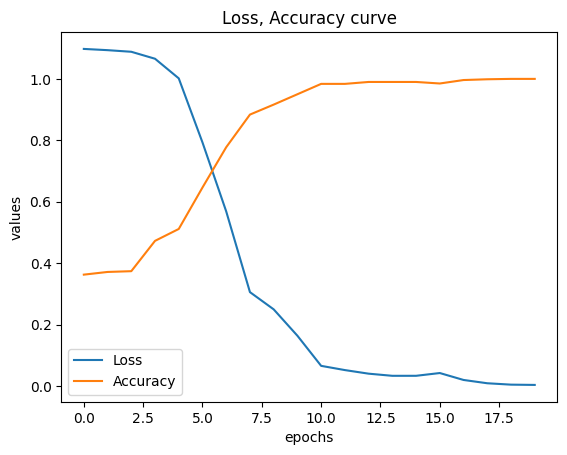

In [19]:
plt.title("Loss, Accuracy curve")
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.xlabel('epochs')
plt.ylabel('values')
plt.legend()
plt.show()

In [20]:
input_headline = 'Khan has planned to attack the mumbai streets, and planted some bombs all over the city.'
cleaned_input = clean_text(input_headline)
input_sequence = tokenizer.texts_to_sequences([cleaned_input])
input_padded = pad_sequences(input_sequence, maxlen=max_length, padding='post', truncating='post')
predicted_probabilities = model.predict(input_padded)
print(predicted_probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
[[0.07333265 0.00173888 0.9249284 ]]


In [21]:
predicted_idx = np.argmax(predicted_probabilities, axis=1)
predicted_sentiment = label_Encoder.inverse_transform(predicted_idx)

print(f"Predicted sentiment for input '{input_headline}': {predicted_sentiment[0]}")

if predicted_sentiment[0] == 1:
    output = 'CRITICAL'
    colored_output = f'\033[91m{output}\033[0m'  # Red
elif predicted_sentiment[0] == 0:
    output = 'SUSPICIOUS'
    colored_output = output  # No color
elif predicted_sentiment[0] == -1:
    output = 'BENIGN'
    colored_output = f'\033[92m{output}\033[0m'  # Green
else:
    output = 'UNKNOWN 😕'
    colored_output = output

confidence = predicted_probabilities[0][predicted_idx[0]]

print(
    f"and the market sentiment is {colored_output} with confidence level {confidence:}"
)


Predicted sentiment for input 'Khan has planned to attack the mumbai streets, and planted some bombs all over the city.': 1
and the market sentiment is CRITICAL with confidence level 0.9249284267425537


In [22]:
from keras.models import model_from_json
model_json = model.to_json()
with open("sentiment.json", "w") as json_file:
    json_file.write(model_json)
model.save("sentiment.h5")
print("Model Saved")

Model Saved
